# Visualize Networkss

In [13]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
import Functions as Fun
import Segregation as Seg

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from forceatlas2 import forceatlas2_networkx_layout

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random
import os
import time
import multiprocessing as mp
import concurrent.futures

# Reload Utils
import importlib
importlib.reload(Seg)
importlib.reload(Fun)

<module 'Functions' from '/mnt/disk2/fcastrillon/Analysis-of-Tweets-During-the-2021-Social-Unrest/Code/Functions.py'>

In [14]:
ls = []
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

for file in files:
    g = gt.load_graph(file)
    N = g.num_vertices()
    ls.append((file,N))

sorted_ls = sorted(ls, key=lambda x: x[1], reverse=True)
sorted_files = [g[0] for g in sorted_ls]

In [17]:
sub_files = sorted_files[0:16]
del sorted_ls

In [37]:
# PASO 0
def initial_pos():
    master_id = pd.read_csv('/mnt/disk2/Data/3_Day_Graphs/Nodes.csv', sep = ';')
    pos = {i: (random.random(), random.random()) for i in master_id['Idx in Graph']}
    return pos

# PASO 1
def read_graph(file, fraction):
    g = gt.load_graph(file)
    g = Fun.fraction_graph(g,fraction)
    date = file.split('/')[-1].split('.')[0].split('_')[-1]    
    g_nx = Fun.to_networkx(g)
    g_nx = g_nx.to_undirected()
    return g_nx, date

# PASO 2.1
def colors_list(g_nx):
    nodes = g_nx.nodes(data=True)
    colors = [node[1]['Color'] for node in nodes]
    return colors

# PASO 2.2
def node_size(g_nx):
    node_degree = [g_nx.degree(node) for node in g_nx.nodes]
    return node_degree

# PASO 2.3
def self_loops(g_nx):
    self_loops = list(nx.selfloop_edges(g_nx))
    non_self_loop_edges = [(u, v) for u, v in g_nx.edges() if (u, v) not in self_loops and (v, u) not in self_loops]
    return non_self_loop_edges

# PASO 3
def layout(g_nx, pos, iter):
    fa2_layout = forceatlas2_networkx_layout(g_nx, pos, niter=iter)
    return fa2_layout

# PASO 4
def draw(g_nx, fa2_layout, node_degree, colors_list, non_self_loop_edges, file):
    fig, ax = plt.subplots(figsize=(18, 12))

    nx.draw_networkx_nodes(g_nx,
                                fa2_layout,
                                node_size = node_degree,
                                node_color = colors_list,
                                edgecolors=(0,0,0,0.1),
                                ax = ax)

    #nx.draw_networkx_edges(g_nx, fa2_layout, edgelist=non_self_loop_edges, alpha=0.1, ax=ax)
    plt.axis('off')
    filename = f'starting_{file}'
    plt.savefig(f'../Results/3_Day_graphs_Viz/{filename}.png')
    plt.close()
    return filename

In [38]:
if __name__ == '__main__':
    
    start = time.perf_counter()
    # PASO 0
    random.seed(427)
    pos = initial_pos()
    iteration=[]
    for i in range(1, 41, 5):     
        def Program(file):
            try:
                start = time.perf_counter()
                # PASO 1
                random.seed(427)
                g_nx, date = read_graph(file,i)
                    
                # PASO 2
                colors = colors_list(g_nx)
                size = node_size(g_nx)
                non_self_loop_edges = self_loops(g_nx)
                    
                # PASO 3 YUCA
                fa2_layout = layout(g_nx, pos, 100)
                    
                # PASO 4
                filename = draw(g_nx, fa2_layout, size, colors, non_self_loop_edges, date)
                #print(f'Done with {filename}')
                
                finish = time.perf_counter()
                return filename
        
            except Exception as e:
                # Log the exception or handle it appropriately
                print(f"Exception in parallel task: {e}")
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
            layouts = executor.map(Program, sub_files)
        
        finish = time.perf_counter()
        iteration.append(finish-start)
        print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 11.92 second(s)
Finished in 271.75 second(s)
Finished in 1196.18 second(s)


KeyboardInterrupt: 

In [40]:
iteration

[11.917949309106916, 271.74816972995177, 1196.1838760836981]

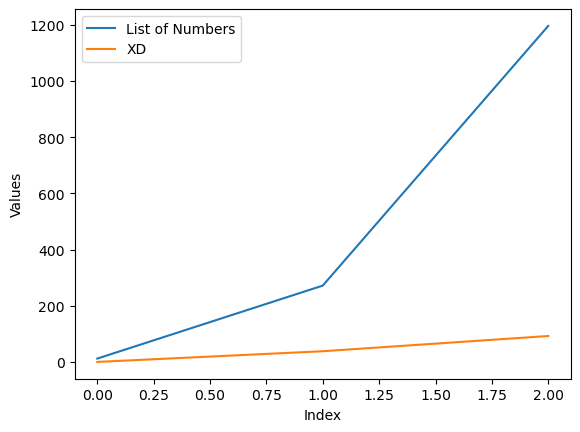

In [39]:
import matplotlib.pyplot as plt
import math
# Example data
list_of_numbers = iteration
range_0_to_100 = list(range(1, len(iteration)*10, 10))
cuadratica = [x*math.log(x,2) for x in [1,6,11]]

# Plotting
plt.plot(list_of_numbers, [1,6,11], label='List of Numbers')
plt.plot(cuadratica, [1,6,11] label='XD')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()